# Chapter 6 -- Convolutional Neural Networks

In this notebook, we will use **[PyTorch](https://pytorch.org/) and [Lightning](https://www.lightning.ai/)** to create and optimize a simple [Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) like the one shown in the picture below. Convolutional neural networks are used for image classification, so when your phone thinks you've taken a picture of a cute kitten, that picture was probably classified with a CNN. In this case, we will create a network that can classify Xs and Os during a game of tic-tac-toe.

<img src="./images/annotated_cnn.png" alt="a simple convolutional neural network" style="width: 800px;">
<!-- <img src="./images/full_cnn.png" alt="a simple convolutional neural network" style="width: 800px;"> -->

In this tutorial, we will:

- Create data and then build a DataLoader
- Build a simple Convolutional Neural Network
- Train the Convolutional Neural Network
- Classify new images

## Prepare the data

### Import PyTorch and Lightning

The very first thing we need to do is load a bunch of Python modules.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"]= (2,2)  # Plot smaler images

### Create Images and then Build a DataLoader From Scratch.

We need to create the images to train and test our neural network. Specifically, we'll create an image of the letters **O** and **X** that look like the pictures below.

<img src="./images/training_data.png" alt="a convolutional neural network" style="width: 600px;">

We'll start by creating the image of the letter **O** by creating a 6x6 matrix of numbers where 0 represents white and 1 represents black.

In [2]:
# Create a 6x6 matrix of numbers where 0 represents white
# and 1 represents black.
o_image = [
    [0, 0, 1, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 0],
    [0, 0, 1, 1, 0, 0],
]

Now, let's create an image of the letter **X** by creating a similar 6x6 matrix, where the 1s are now in an **X** pattern.

In [3]:
x_image = [
    [1, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 1],
]

By squinting at the matrices we created for `o_image` and `x_image`, we can sort of see that we made them correctly. However, by drawing the images with matplotlib, we can get a much clearer picture, or rather, we can get much clearer pictures, of what we have done so far.

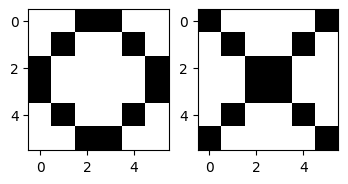

In [4]:
# To draw the o_image and x_image, we first call subplots(), which creates 
# an array, called axarr[], with an entry for each element in a grid
# specified by nrows and ncols.
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))

# Now we pass o_image and x_image to .imshow() for each element
# in the grid created by plt.subplots()
axarr[0].imshow(o_image, cmap='gray_r')  # Setting cmap='gray_r' or 'binary' gives us reverse grayscale.
axarr[1].imshow(x_image, cmap='gray_r');

Now, let's put our training data into a **DataLoader**, which we can use to train the neural network. **DataLoaders** are great for large datasets because they make it easy to access the data in batches, make it easy to shuffle the data each epoch, and they make it easy to use a relatively small fraction of the data if we want to do a quick and dirty training for debugging our code.

To put our data training data into a **DataLoader**, we start by converting the images into tensors with `torch.tensor()` and save them as `input_images`.

_NOTE: When we call `torch.tensor()`, we tack on `type(torch.float32)` to ensure the numbers are saved in the correct format for the neural network to process efficiently._

In [5]:
# Convert the images into tensors...
input_images = torch.tensor([o_image, x_image]).type(torch.float32)

Then, we create tensors for the labels, the ideal output values given each input image. In this example, our convolutional neural network has 2 outputs, one for the letter **O** and one for the letter **X**, so `[1.0, 0.0]` will represent the ideal output for the letter **O**, and `[0.0, 1.0]` will represent the ideal output for the letter **X**. The labels will be saved in `input_labels`.

In [6]:
# Create the labels for the input images
input_labels = torch.tensor([
    [1.0, 0.0],   # Codes for label 0
    [0.0, 1.0]],  # Codes for label 1
dtype=torch.float32)

Finally, we combine `input_images` with `input_labels` to create a **TensorDataset** and use the **TensorDataset** to create the **DataLoader**.

In [7]:
# Now combine input_images and input_labels into a TensorDataset
dataset = TensorDataset(input_images, input_labels) 
dataloader = DataLoader(dataset)

Now, just for fun, we can verify that `dataloader` contains the input images and labels by using it in a `for` loop and printing out the images and labels.

In [8]:
for batch_num, (images, labels) in enumerate(dataloader):
    print("batch_num:", batch_num)
    print(images)
    print(labels)
    print()  # print a blank line to separate each batch

batch_num: 0
tensor([[[0., 0., 1., 1., 0., 0.],
         [0., 1., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 1., 0.],
         [0., 0., 1., 1., 0., 0.]]])
tensor([[1., 0.]])

batch_num: 1
tensor([[[1., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 1., 0.],
         [0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 1., 0., 0.],
         [0., 1., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 1.]]])
tensor([[0., 1.]])



At long last, we have created the **DataLoader** that we will use to train a convolutional neural network. Now, let's build it!

## Building a Convolutional Neural Network (CNN)

Building a CNN with PyTorch means creating a new class. And to make it easy to train the neural network, this class will inherit from `LightningModule`.

Our new class will have the following methods:

- `__init__()` to initialize the weights and biases and keep track of a few other housekeeping things.
- `forward()` to make a forward pass through the convolutional neural network.
- `configure_optimizers()` to configure the optimizer. In this tutorial, we'll use `Adam`.
- `training_step()` to pass the training data to `forward()`, calculate the loss, and keep track of the loss values in a log file.

Here is a picture of the neural network we want to create:

<img src="./images/full_cnn.png" alt="a simple convolutional neural network" style="width: 800px;">

As we can see in the picture, our convolutional neural network accepts a 6x6 image as the input. Then, it applies a 3x3 **filter**, or **kernel**, to the image. That is the **convolutional** step in a Convolutional Neural Network. Anyway, then we run the output from the filter through a **ReLU** activation function before a **max pooling** step. Lastly, we run the max pooling values through a *simple neural network* with 4 inputs and 2 outputs.

Don't forget that all of them are being determined or optimized after backpropagation: the kernel matrix (that is initiated with random values), the biais to its output ant that goes to the **feature map**, then the ReLU function setting all the negative values to zero. Finally a filter will select the maximum value in non-overlaping squares (max pooling). This will be converted to a column tensor and will be used as an input to a standard neural network, with weights and biaises

_NOTE: this specific convolutional neural network is super simple. Usually, the images have multiple color channels (one for red, one for blue, and one for green), and multiple filters are applied to each channel. The output from these filters can then be run through multiple layers of filters. In contrast, our example is super simple, so we'll call it `SimpleCNN`._

In [9]:
class SimpleCNN(L.LightningModule):

    def __init__(self):
        super().__init__()

        L.seed_everything(seed=42)

        ################################################################
        # Here is where we initialize the Weights and Biases for the CNN
        ################################################################

        # The filter is created and applied by nn.Conv2d().
        # in_channels - The number of color channels that
        #    the image has. Our black and white image only 
        #    has one channel. However, color pictures usually have 3.
        # out_channels - If we had multiple input channels, we could merge
        #    them down to one output. Or we can increase the number of
        #    output channels if we want.
        # kernel_size - The size of the filter (aka kernel). In this case
        #    we want a 3x3 filter, but you can select all kinds of sizes,
        #    including sizes that are more rectangular than square.
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

        # nn.MaxPool2d() does the max pooling step.
        # kernel_size - The size of the filter (aka kernel) that does the
        #    max pooling. We're using a 2x2 grid for our filter.
        # stride - How much to move the filter each step. In this case
        #    we're moving it 2 units. Thus, our 2x2 filter does max pooling
        #    before moving 2 units over (or down). This means that our 
        #    max pooling filter never overlaps itself.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lastly, we create the "normal" neural network that has
        # 4 inputs, in_features=4, going to a single activation function, out_features=1, 
        # in a single hidden layer.
        self.input_to_hidden = nn.Linear(in_features=4, out_features=1)
        # and the single hidden layer, in_features=1, goes to
        # two outputs, out_features=2
        self.hidden_to_output = nn.Linear(in_features=1, out_features=2)

        # We'll use Cross Entropy to calculate the loss between what the 
        # neural network's predictions and actual, or known, species for
        # each row in the dataset.
        # NOTE: nn.CrossEntropyLoss applies a SoftMax function to the values
        # we give it, so we don't have to do that oursevles. However,
        # when we use this neural network (after it has been trained), we'll
        # have to remember to apply a SoftMax function to the output.
        self.loss = nn.CrossEntropyLoss()


    def forward(self, x):
        
        # First we apply a filter to the input image
        x = self.conv(x)

        # Then we run the output from the filter through a ReLU
        x = F.relu(x)

        # Then we run the output from the ReLU through a Max Pooling layer
        x = self.pool(x)

        # Now, at this point we have a square matrix of values.
        # So, in order to use those values as inputs to
        # a neural network, we use torch.flatten() to 
        # turn the matrix into a vector.
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        # Now we run the flattened values through a neural network
        # with a single hidden layer and a single ReLU activation
        # function in that layer.
        x = self.input_to_hidden(x)
        x = F.relu(x)
        x = self.hidden_to_output(x)

        return x


    def configure_optimizers(self):
        # In this example, configuring the optimizer
        # consists of passing it the weights and biases we want
        # to optimize, which are all in self.parameters(),
        # and setting the learning rate with lr=0.001.
        return Adam(self.parameters(), lr=0.001)


    def training_step(self, batch, batch_idx):
        # The first thing we do is split 'batch'
        # into the input and label values.
        inputs, labels = batch

        # Then we run the input through the neural network
        outputs = self.forward(inputs)

        # Then we calculate the loss.
        loss = self.loss(outputs, labels)

        # Lastly, we could add the loss to a log file
        # so that we can graph it later. This would
        # help us decide if we have done enough training
        # Ideally, if we do enough training, the loss
        # should be small and not getting any smaller.
        # self.log("loss", loss)

        return loss

Note that we can refactor the class using `nn.Sequential` and modules, e.g., ReLu and flatten, instead of functions, and make the code a bit cleaner.

In [10]:
class SimpleCNN(L.LightningModule):

    def __init__(self):
        super().__init__()

        L.seed_everything(seed=42)

        # We define the entire network as one sequential block
        self.net = nn.Sequential(
            
            # 1. Convolutional Part
            # (Corresponds to self.conv(x) and F.relu(x))
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
            nn.ReLU(),
            
            # 2. Pooling Part
            # (Corresponds to self.pool(x))
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 3. Flattening Part
            # (Corresponds to torch.flatten(x, 1))
            # This converts the 2D feature map into a 1D vector
            nn.Flatten(start_dim=1), # start_dim=1 keeps the batch dimension

            # 4. Fully-Connected (Classifier) Part
            # (Corresponds to the rest of the original forward pass)
            nn.Linear(in_features=4, out_features=1),
            nn.ReLU(),
            nn.Linear(in_features=1, out_features=2)
        )
        
        # The loss function remains the same
        self.loss = nn.CrossEntropyLoss()


    def forward(self, x):
        # The forward pass is now just one clean line
        return self.net(x)


    def configure_optimizers(self):
        # This method remains exactly the same
        return Adam(self.parameters(), lr=0.001)


    def training_step(self, batch):
        # This method remains exactly the same
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, labels)

        return loss

## Training the CNN

Training our new convolutional neural network means we create a model from the new class, `SimpleCNN`.

In [11]:
model = SimpleCNN()

Seed set to 42


And then create a **Lightning Trainer**, `L.Trainer()`, and use it to optimize the parameters. _NOTE: We will start with 100 epochs, 100 complete runs through our training data. This may be enough to successfully optimize all of the parameters, but it might not._

In [12]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model, train_dataloaders=dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sébastien\Documents\data_science\machine_learning\statsquest_neural_networks\.env\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name | Type             | Params | Mode 
---------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Now, let's see if the predictions are any good. We can do this by seeing how well it classifies the original training data. And we can do this using a `for` loop, just like we did earlier when we used to print out the contents of the **DataLoader** that we used for training.

The **CrossEntropy** loss function we use during training applies a SoftMax function to the outputs. Thus, now that we're using the model, we'll apply `torch.softmax()` to its output. This will make it easier to read and interpret. And to make it even easier to read, we can run it through `torch.round()`.

In [13]:
for batch_num, (image, label) in enumerate(dataloader):
    
    # First, run the image through the model to make a prediction
    prediction = model(image)

    # Now make the prediction easy to read and interpret by
    # running it through torch.softmax() and torch.round()
    predicted_label = torch.round(
        torch.softmax(prediction, dim=1),  # dim=0 applies softmax to rows, dim=1 to columns
        decimals=2)

    # Now print out the the predicted label and the original label
    # so we see how well our CNN performed.
    print("predicted_label:", predicted_label)
    print("original label:", label)

predicted_label: tensor([[0.5200, 0.4800]], grad_fn=<RoundBackward1>)
original label: tensor([[1., 0.]])
predicted_label: tensor([[0.4200, 0.5800]], grad_fn=<RoundBackward1>)
original label: tensor([[0., 1.]])


As we can see in the output printed above, after 100 epochs of training, our convolutional neural network is not making good predictions. So let's do a lot more training.

Here again, we can pick up where we left off training without starting over from scratch. This is because training with **Lightning** creates _checkpoint_ files that keep track of the Weights and Biases as they change. As a result, all we have to do to pick up where we left off is tell the `Trainer` where the checkpoint files are. This will save us a lot of time since we don't have to retrain the first **100** epochs. So, let's add an additional **600** epochs to the training.

To add additional epochs to the training, we first identify where the checkpoint file is with the following command.

In [14]:
path_to_checkpoint = trainer.checkpoint_callback.best_model_path  # By default, "best" = "most recent"

Then we create a new **Lightning Trainer**, just like before, but we set the number of epochs to 700. Given that we already trained for 100 epochs, this means we'll do 600 more.

In [15]:
# First, create a new Lightning Trainer
trainer = L.Trainer(max_epochs=700)

# Then call trainer.fit() using the path to the most recent checkpoint files
# so that we can pick up where we left off.
trainer.fit(model, train_dataloaders=dataloader, ckpt_path=path_to_checkpoint)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at c:\Users\Sébastien\Documents\data_science\machine_learning\statsquest_neural_networks\chapter_06\lightning_logs\version_4\checkpoints\epoch=99-step=200.ckpt
c:\Users\Sébastien\Documents\data_science\machine_learning\statsquest_neural_networks\.env\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:445: The dirpath has changed from 'c:\\Users\\Sébastien\\Documents\\data_science\\machine_learning\\statsquest_neural_networks\\chapter_06\\lightning_logs\\version_4\\checkpoints' to 'c:\\Users\\Sébastien\\Documents\\data_science\\machine_learning\\statsquest_neural_networks\\chapter_06\\lightning_logs\\version_5\\checkpoin

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=700` reached.


Now, let's see if the predictions have improved after 700 epochs. We'll do this using the same `for` loop that we used before.

In [16]:
for batch_num, (image, label) in enumerate(dataloader):
    
    prediction = model(image)

    predicted_label = torch.round(
        torch.softmax(prediction, dim=1),
        decimals=2)

    print("predicted_label:", predicted_label)
    print("original label:", label)

predicted_label: tensor([[0.7900, 0.2100]], grad_fn=<RoundBackward1>)
original label: tensor([[1., 0.]])
predicted_label: tensor([[0.0100, 0.9900]], grad_fn=<RoundBackward1>)
original label: tensor([[0., 1.]])


After 700 training epochs, the predicted values are much, much closer to the ideal values. And if we rounded them to the nearest whole number, we'd get the exact labels that we wanted.

## Make a Prediction with New Data

Now that our model is trained, we can use it to make predictions from new data. Specifically, let's see how well our model predicts an image of the letter **X** that has been shifted over one pixel. First, let's create the image of an **X** shifted by one pixel to the right.

In [17]:
shifted_x_image = [
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 0, 1],
    [0, 1, 0, 0, 0, 0]]

Now, let's verify that we created the correct image by drawing with matplotlib, just like we did earlier.

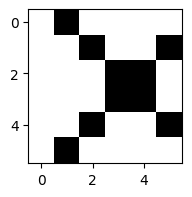

In [18]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(shifted_x_image, cmap='gray_r');

Now that we can see that we correctly created an image of an **X** shifted one pixel to the right, let's see whether or not our trained convolutional neural network can correctly classify it as an **X**.

In [19]:
# First, let's make a prediction with the new image
prediction = model(
    torch.tensor([shifted_x_image]).type(torch.float32))

# Now make the prediction easy to read and interpret by
# running it through torch.softmax() and torch.round()
predicted_label = torch.round(
    torch.softmax(prediction, dim=1),
    decimals=2)

predicted_label

tensor([[0.1200, 0.8800]], grad_fn=<RoundBackward1>)

And we see that the trained network correctly predicted **X** since the second output value, which represents **X**, is larger than the first output value, which represents **O**.

Now, let's see if our trained network can correctly classify an image of the letter **O** that is shifted one pixel to the left. We'll do this just like we did for the shifted **X**. So, the first thing we do is create the image.

In [20]:
shifted_o_image = [
    [0, 1, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 0]]

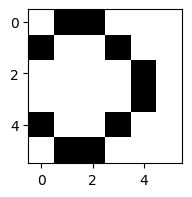

In [21]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(shifted_o_image, cmap='gray_r');

Lastly, we run the image through the trained network to make a prediction...

In [22]:
prediction = model(
    torch.tensor([shifted_o_image]).type(torch.float32))

predicted_label = torch.round(
    torch.softmax(prediction, dim=1),
    decimals=2)

predicted_label

tensor([[0.4500, 0.5500]], grad_fn=<RoundBackward1>)

And it looks like our network thought that the shifted **O** was an **X**. Oh well...

However, we learned a lot, and with more training data and more variation in the letters, we might be able to make better predictions in the future!